In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [3]:
name_dataset = 'biblioteka'

### load data

In [4]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(88, 7)
CPU times: user 10 ms, sys: 4.76 ms, total: 14.8 ms
Wall time: 16.6 ms


In [5]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1914-09-16 12:00:00,https://lenta.ru/news/1914/09/16/hungarnn/,NaN,Библиотека / Первая мировая,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека
1,1914-09-16 12:00:00,https://lenta.ru/news/1914/09/16/lermontov/,NaN,Библиотека / Первая мировая,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека


### preprocess

* get dates

In [6]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 1.56 ms, sys: 548 µs, total: 2.11 ms
Wall time: 2.02 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [7]:
import preprocessing_tools as pr

In [8]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 17 ms, sys: 880 µs, total: 17.9 ms
Wall time: 17.4 ms


In [9]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1914-09-16 12:00:00,https://lenta.ru/news/1914/09/16/hungarnn/,NaN,Библиотека / Первая мировая,1914. Русские войска вступили в пределы Венгрии,бои у сопоцкина и друскеник закончились отступ...,Библиотека,"[(1914, 09, 16)]",1914,9
1,1914-09-16 12:00:00,https://lenta.ru/news/1914/09/16/lermontov/,NaN,Библиотека / Первая мировая,1914. Празднование столетия М.Ю. Лермонтова от...,министерство народного просвещения в виду прои...,Библиотека,"[(1914, 09, 16)]",1914,9


* cleanedNames

In [10]:
from cleanedNames import KeyProc
cn = KeyProc()

In [11]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 121 ms, sys: 0 ns, total: 121 ms
Wall time: 120 ms


* lemmatization

In [12]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 1.05 s, sys: 0 ns, total: 1.05 s
Wall time: 1.05 s


* add docID

In [13]:
df['docID'] = list(range(df.shape[0]))

In [14]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1914,9,"[бой, сопоцкина, друскеник, закончиться, отсту..."
1,1,1914,9,"[министерство, народный, просвещение, вид, про..."


In [15]:
print(df.shape)
df.isnull().sum()

(88, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [16]:
df.year.min()

1914

## model

* prepare

In [17]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 2.49 ms, sys: 603 µs, total: 3.09 ms
Wall time: 14.9 ms


In [18]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [19]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/biblioteka", num_batches=1)
CPU times: user 63.5 ms, sys: 1.64 ms, total: 65.2 ms
Wall time: 47.5 ms


In [20]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [21]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=5253ca62-d6da-4c47-a5e0-1602bacf3392, num_entries=45)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [23]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.8693181872367859
	SparsityPhiScore: 0.9888888597488403
	PerplexityScore: 749.4437255859375
	time: 0:00:00.553583
#topic 3.........
	SparsityThetaScore: 0.9090909361839294
	SparsityPhiScore: 1.0
	PerplexityScore: 851.2720336914062
	time: 0:00:00.491949
#topic 4.........
	SparsityThetaScore: 0.9090909361839294
	SparsityPhiScore: 1.0
	PerplexityScore: 851.2720336914062
	time: 0:00:00.491826
#topic 5.........
	SparsityThetaScore: 0.9090909361839294
	SparsityPhiScore: 1.0
	PerplexityScore: 851.2720336914062
	time: 0:00:00.515819
#topic 6.........
	SparsityThetaScore: 0.9090909361839294
	SparsityPhiScore: 1.0
	PerplexityScore: 851.2720336914062
	time: 0:00:00.514447
#topic 7.........
	SparsityThetaScore: 0.9090909361839294
	SparsityPhiScore: 1.0
	PerplexityScore: 851.2720336914062
	time: 0:00:00.541922
#topic 8.........
	SparsityThetaScore: 0.9090909361839294
	SparsityPhiScore: 1.0
	PerplexityScore: 851.2720336914062
	time: 0:00:00.531348
#topic 9....

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

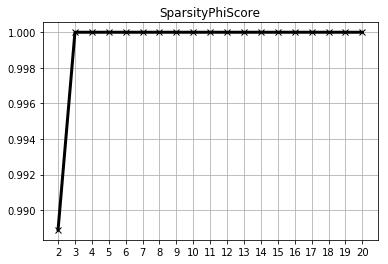

In [24]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [25]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.9, 1.0]

In [26]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.9: 1, 1.0: 18}

Text(0.5, 1.0, 'SparsityThetaScore')

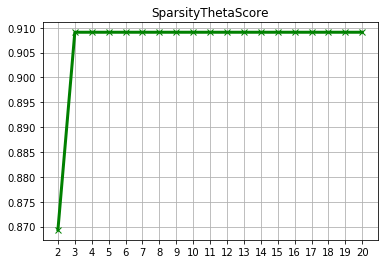

In [27]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [28]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.8, 0.9]

In [29]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.8: 1, 0.9: 18}

Text(0.5, 1.0, 'PerplexityScore')

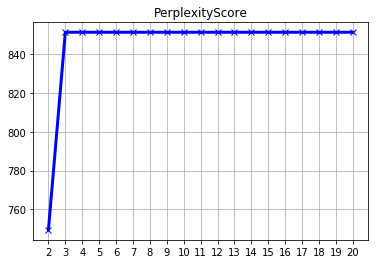

In [30]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [31]:
perplexity

[749.4437255859375,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062,
 851.2720336914062]

### select the best model

In [32]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.9: 1, 1.0: 18}
d_stheta: {0.8: 1, 0.9: 18}


In [33]:
select_topics = 2 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

2


### print top words for each topics

In [34]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['тычинина' 'друг' 'пленный' 'го' 'рубль' 'дом' 'фестиваль' 'хороший'
 'англичанин' 'морской']
topic_1: ['хороший' 'тычинина' 'друг' 'пленный' 'го' 'рубль' 'дом' 'фестиваль'
 'англичанин' 'морской']


### get topics-docs matrix

shape theta: (2, 15)


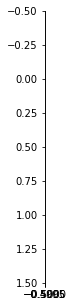

In [36]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(5, 5))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [37]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


## DataViz

In [38]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1
0,0,1914,9,0.0,0.0
1,1,1914,9,0.0,0.0
2,2,1914,9,0.0,0.0
3,3,1914,9,0.0,0.0
4,4,1914,9,0.0,0.0


In [39]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (26, 2)


topic_0  topic_1
year month                  
1914 9          0.0      0.0
2000 9          0.0      0.0
2001 5          0.0      0.0
     11         0.0      0.0
2002 1          0.0      1.0

### straightforward matrix heatmap

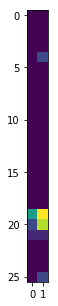

In [42]:
plt.figure(figsize=(5, 5))
plt.imshow(gb[topics])

## pygal

In [43]:
import pygal
from IPython.display import SVG, HTML

In [44]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [45]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [46]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [47]:
import joypy # !pip install joypy

In [48]:
print(joined.shape)
joined.head()

(88, 5)


,docID,year,month,topic_0,topic_1
0,0,1914,9,0.0,0.0
1,1,1914,9,0.0,0.0
2,2,1914,9,0.0,0.0
3,3,1914,9,0.0,0.0
4,4,1914,9,0.0,0.0


In [49]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,year_month
0,0,0,1914,9,0.0,0.0,1914-9-01
1,1,1,1914,9,0.0,0.0,1914-9-01
2,2,2,1914,9,0.0,0.0,1914-9-01
3,3,3,1914,9,0.0,0.0,1914-9-01
4,4,4,1914,9,0.0,0.0,1914-9-01


In [50]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(528, 3)


,year_month,topic,text
0,1914-9-01,index,0.0
1,1914-9-01,index,1.0
2,1914-9-01,index,2.0
3,1914-9-01,index,3.0
4,1914-9-01,index,4.0


In [51]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(176, 3)


topic_0    88
topic_1    88
Name: topic, dtype: int64

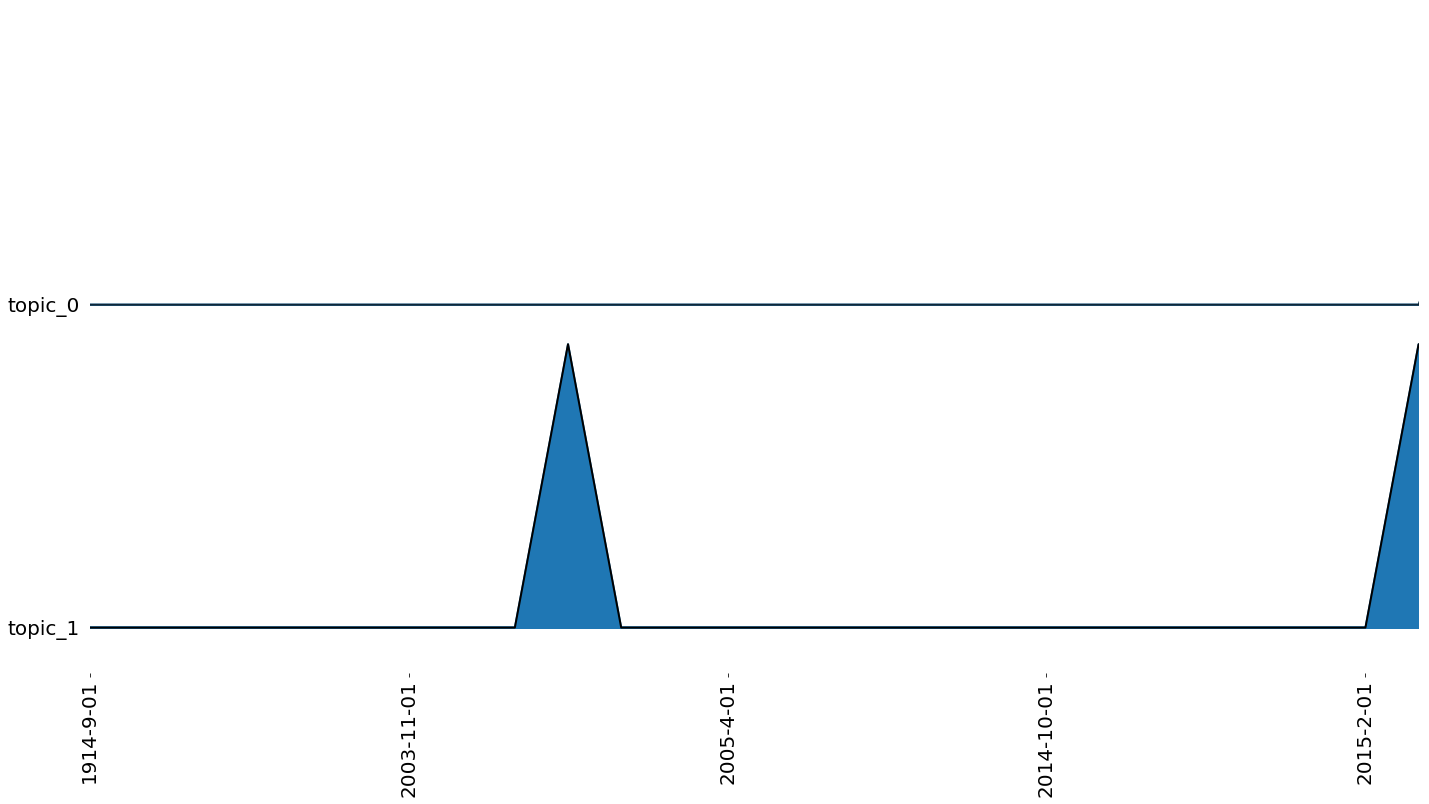

In [52]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [53]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")